В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.
Review criteriaменьше 
Придерживайтесь стандартного алгоритма построения прогноза:

Визуальный анализ ряда
Стабилизация дисперсии (при необходимости)
Выбор порядка дифференцирования
Выбор начальных приближений для p,q,P,Q
Обучение и сравнение моделей-кандидатов, выбор победителя
Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.
Прогнозирование с помощью финальной модели.
Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

# Прогнозирование уровня средней заработной платы в России

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016, необходимо построить прогноз на следующие два года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/truename/anaconda3/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


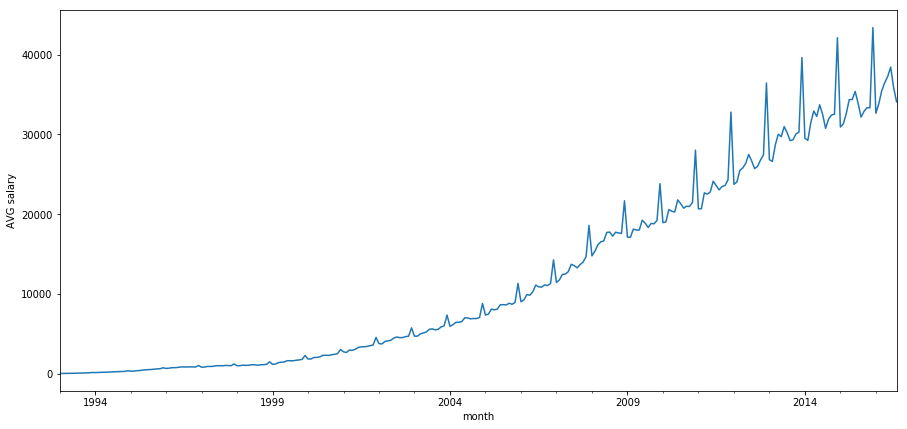

In [6]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
#salary.head()
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('AVG salary')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


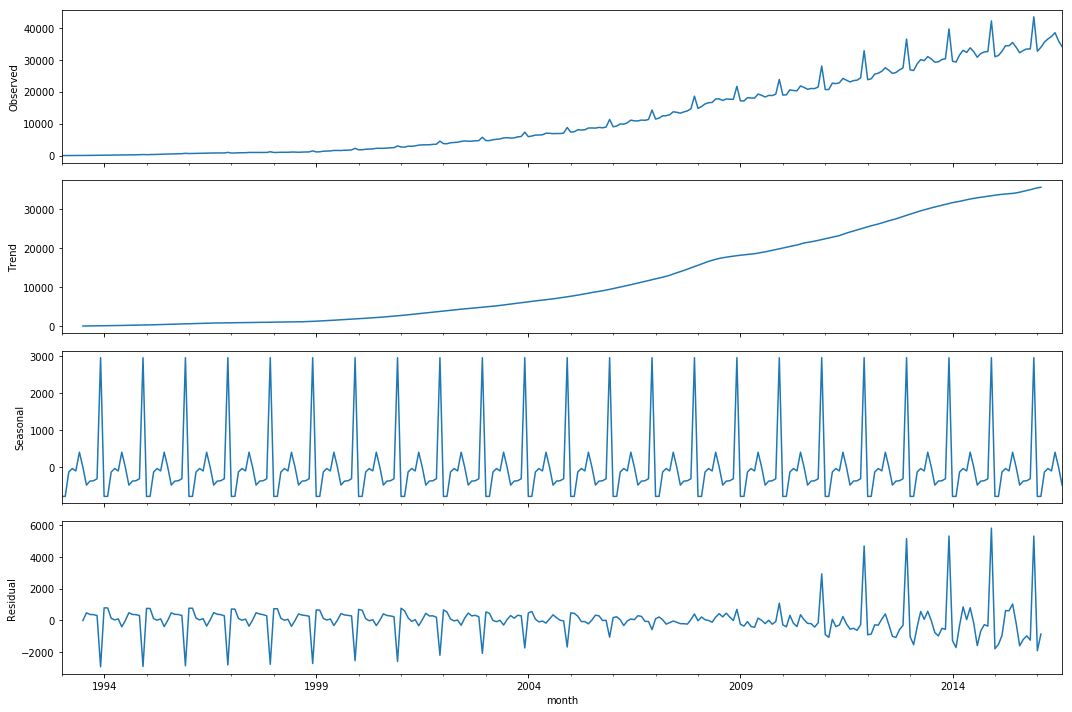

In [7]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

Видим восходящий тренд и годовую сезонность, увеличение дисперсии с увеличением времени.
Значит начнем со стабилизации дисперсии.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


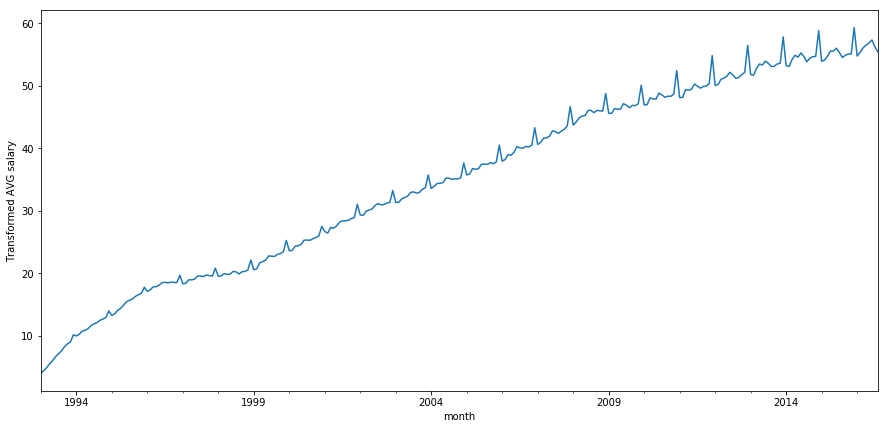

In [8]:
salary['WAG_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.WAG_box.plot()
plt.ylabel(u'Transformed AVG salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_box)[1])

Как видим, критерий Дики-Фуллера не позволяет отвергнуть нулевую гипотезу о нестационарности ряда. Переходим к дифференцированиям.

### Стационарность

Визуально в данных виден тренд. Дифференцирование начнем с сезонного; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


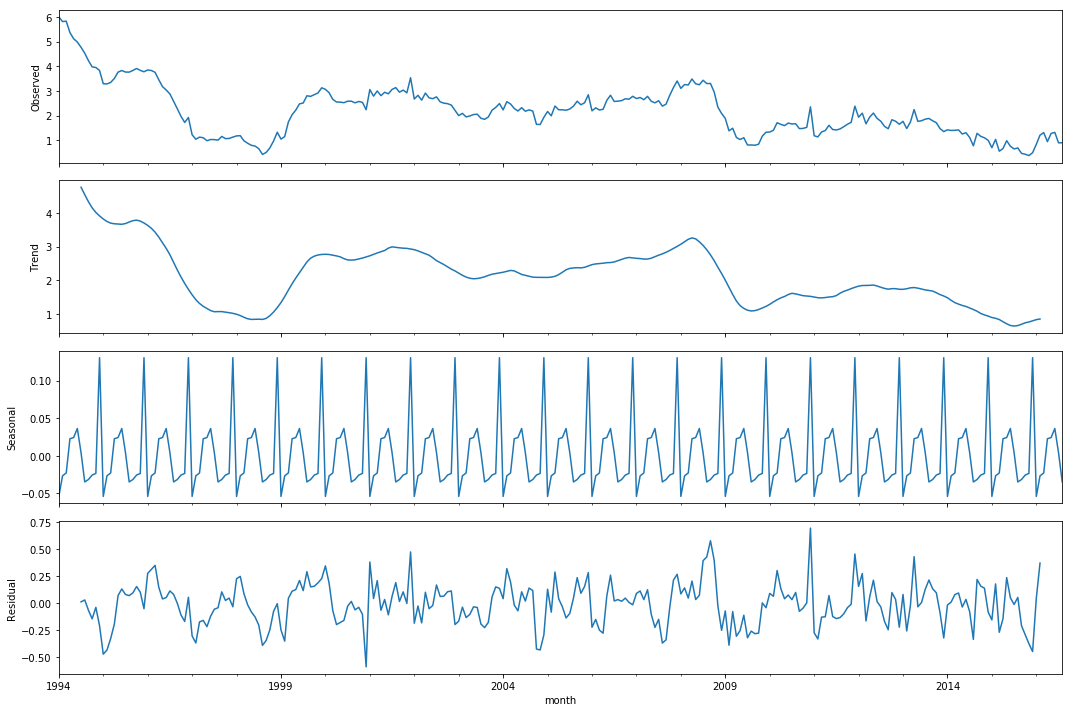

In [11]:
salary['WAG_box_diff'] = salary.WAG_box - salary.WAG_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось - наблюдается сложный нисходящий тренд. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


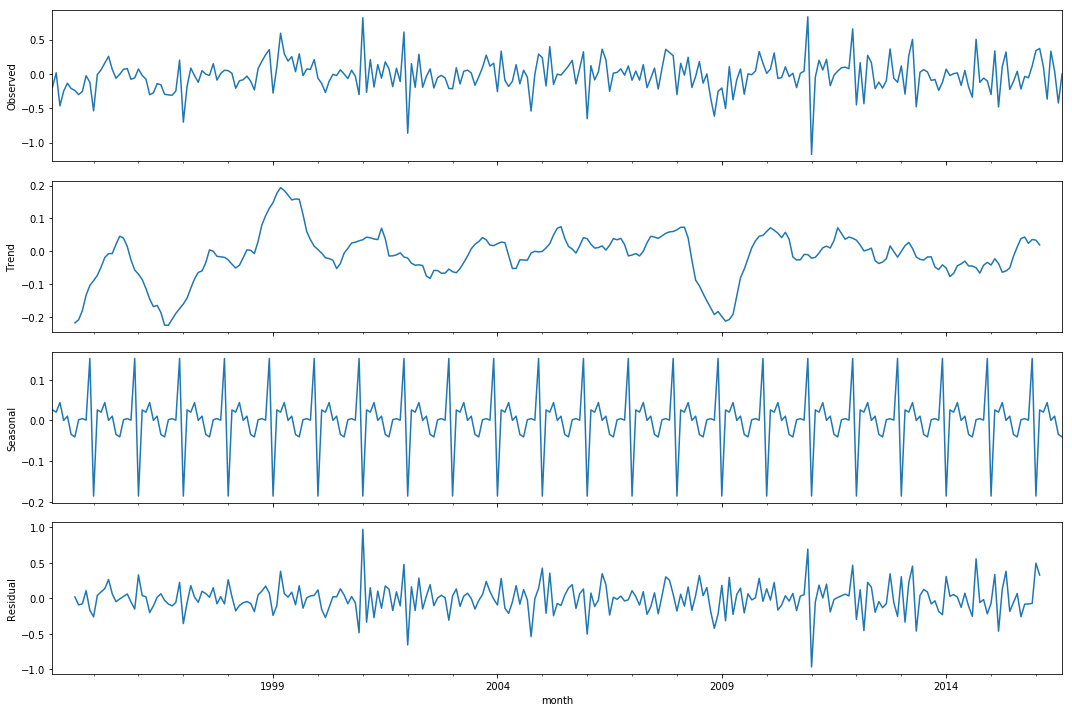

In [12]:
salary['WAG_box_diff2'] = salary.WAG_box_diff - salary.WAG_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_box_diff2[13:])[1])

Гипотеза нестационарности уверенно отвергается, но теперь визуально ряд выглядит лучше — заметного тренда больше нет, колебания тренда около константы.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

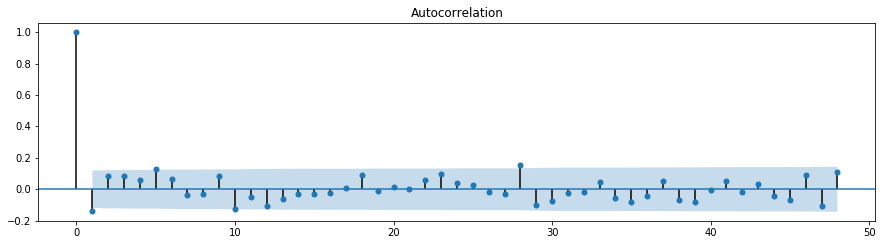

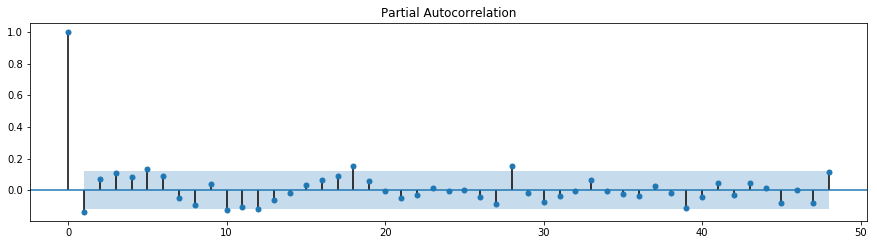

In [13]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.WAG_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.WAG_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Вот тут самая "муть" =)
Начальные приближения: 
1. Смотрим график автокорреляции. Сезонных лагов (кратных 12, раз у нас данные по годам по 12 месяцев с выраженной сезонностью в 12 месяцев) на графике не вижу - значимые значения 1,10 и 28 не кратны 12 => Q=0 (0/12=0)

2. Смотрим график автокорреляции. Несезонный лаг (не кратные 12, раз у нас данные по годам по 12 месяцев с выраженной сезонностью в 12 месяцев) на графике 1 (бОльше значимые значения (10 и 28) брать не стоит, т.к. это сильно увеличивает модель) - берем номер последнего => q=1

3. Смотрим график частичной автокорреляционной функции, ищем сезонные лаги и берем последний (находим кратные 12 только со значением 12, оставшиеся значимые значения 18,28,39 не кратны 12) => P=1 (12/12=1)

4. Смотрим график частичной автокорреляционной функции, ищем несезонные лаги и берем последний в разумных пределах, чтобы не увеличивать сильно нашу модель (1,10,18,28) => p=1

In [49]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [50]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [51]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.WAG_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
CPU times: user 3.06 s, sys: 10.8 s, total: 13.8 s
Wall time: 1.98 s


In [52]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
4  (1, 0, 1, 0)  0.340521
2  (0, 1, 1, 0)  1.170768
6  (1, 1, 1, 0)  2.021911
3  (1, 0, 0, 0)  2.625709
1  (0, 1, 0, 0)  3.369832


Лучшая модель:

In [18]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            WAG_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sat, 02 Dec 2017   AIC                              0.341
Time:                                    12:29:48   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Её остатки:

Критерий Стьюдента: p=0.090792
Критерий Дики-Фуллера: p=0.000003


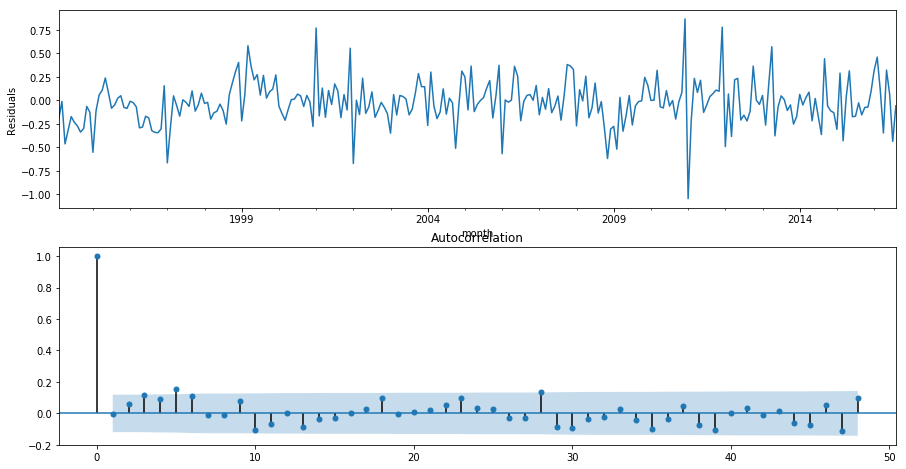

In [27]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

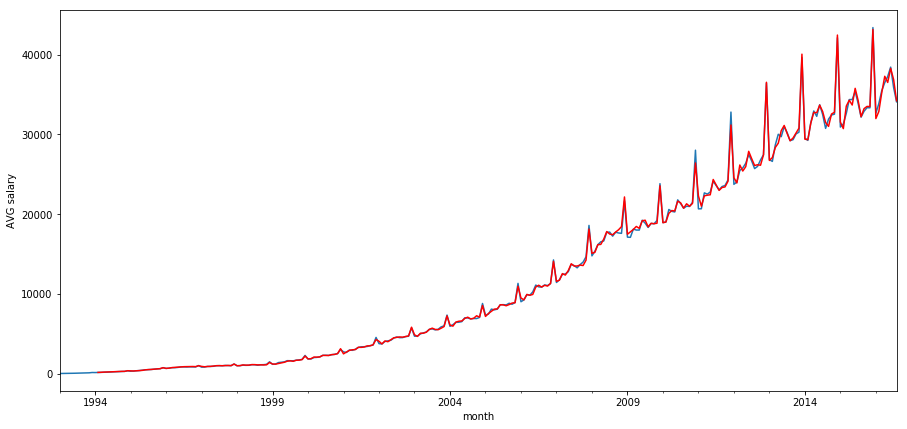

In [28]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('AVG salary')
pylab.show()

Видим, что модель достаточно хорошо описывает данные.

### Прогноз

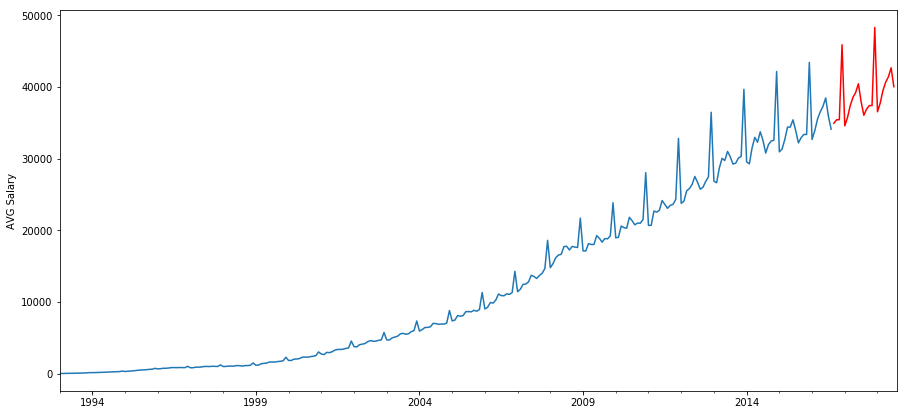

In [44]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=306), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('AVG Salary')
pylab.show()

Как видим, прогноз достаточно хорошо повторяет тренд и общий характер данных.
Здорово! =)